In [1]:
import pandas as pd
import numpy as np
import splitfolders

import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import datasets
from torchvision import transforms

from PIL import Image
import matplotlib.pyplot as plt



In [2]:
splitfolders.ratio("chromate",output="chromate_split",seed=100,ratio=(.8,.1,.1)) #splitfolders로 폴더 나눠주기.

Copying files: 174 files [00:00, 358.02 files/s]


In [3]:
def augment_dataset(num_of_aug,set_type='train',policy=transforms.AutoAugmentPolicy.SVHN) :
    ''' 
    num_of_aug : original dataset에 autoaugment 진행해서 더해줄 cycle의 수.
    (예시로 x -> 2x -> 3x ..)

    set_type : train만 쓰시오(기본값=train)

    policy : 굳이 바꿔주고 싶으면 pytorch docs 확인해서 바꾸시오. AutoAugment 종류
    '''

    Compose_dataset = transforms.Compose([
            transforms.AutoAugment(policy),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
            [0.485, 0.456,0.406], 
            [0.229, 0.224, 0.225]),
        ])

    result_dataset = []

    for _ in range(num_of_aug):
        
        dataset = datasets.ImageFolder(
                root=f"./chromate_split/{set_type}", #path 바꾸시오 안될수도 있음.
                transform=Compose_dataset
            )
        
        
        result_dataset = torch.utils.data.ConcatDataset([result_dataset, dataset])

    return result_dataset


val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406], 
        [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406], 
        [0.229, 0.224, 0.225])])
                                                                                                                                                       

In [4]:
train_dataset = augment_dataset(3,'train')

val_dataset = datasets.ImageFolder(
            root='./chromate_split/val',
            transform=val_transforms)

test_dataset = datasets.ImageFolder(
            root='./chromate_split/test',
            transform=test_transforms)

print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))


417
18
17


In [5]:
train_loader = torch.utils.data.DataLoader(
            train_dataset, 
            batch_size=4,
            shuffle=True, 
            num_workers=4)

val_loader = torch.utils.data.DataLoader(
            val_dataset, 
            batch_size=4,
            shuffle=True, 
            num_workers=4)

test_loader = torch.utils.data.DataLoader(
            test_dataset, 
            batch_size=1,
            shuffle=False)


In [6]:
model = torchvision.models.resnet50(pretrained=True)
print(model.fc)

c:\Users\rhcp1\anaconda3\envs\py_3_10_4\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rhcp1\anaconda3\envs\py_3_10_4\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=2048, out_features=1000, bias=True)


In [7]:
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=0.001, 
                      momentum=0.9) 

exp_lr_scheduler = StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

In [8]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [9]:
# early_stopping 객체 선언(3번의 epoch 연속으로 loss 미개선 시에 조기 종료 예시)
es = EarlyStopping(patience = 3, verbose = True, delta=0.001, path='./chromate_resnet.pt')

num_epochs= 10

for epoch in range(num_epochs):
  # Train
  model.train()
  running_loss = 0.0
  running_corrects = 0

  for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()/inputs.size(0)
        running_corrects += \
        torch.sum(preds == labels.data)/inputs.size(0)

  exp_lr_scheduler.step()
  train_epoch_loss = running_loss / len(train_loader)
  train_epoch_acc = running_corrects / len(train_loader)
  
 # Validation
  model.eval() 
  running_loss = 0.0
  running_corrects = 0
 
  for inputs, labels in val_loader: 
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs,1)
      loss = criterion(outputs, labels)

      running_loss += loss.item()/inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)/inputs.size(0)

  epoch_loss = running_loss / len(val_loader)
  epoch_acc = running_corrects.double() / len(val_loader)
  
  es(-epoch_acc, model)
  if es.early_stop:
    print(epoch, loss.item())
    break  
  print("Train: Loss: {:.4f} Acc: {:.4f}"
    " Val: Loss: {:.4f}"
    " Acc: {:.4f}".format(train_epoch_loss,
                         train_epoch_acc,
                         epoch_loss,
                         epoch_acc))

Validation loss decreased (inf --> -1.000000).  Saving model ...
Train: Loss: 0.2401 Acc: 0.8143 Val: Loss: 0.0028 Acc: 1.0000
EarlyStopping counter: 1 out of 3
Train: Loss: 0.0636 Acc: 0.9214 Val: Loss: 0.0058 Acc: 1.0000
EarlyStopping counter: 2 out of 3
Train: Loss: 0.0739 Acc: 0.9000 Val: Loss: 0.0007 Acc: 1.0000
EarlyStopping counter: 3 out of 3
3 4.207999518257566e-05


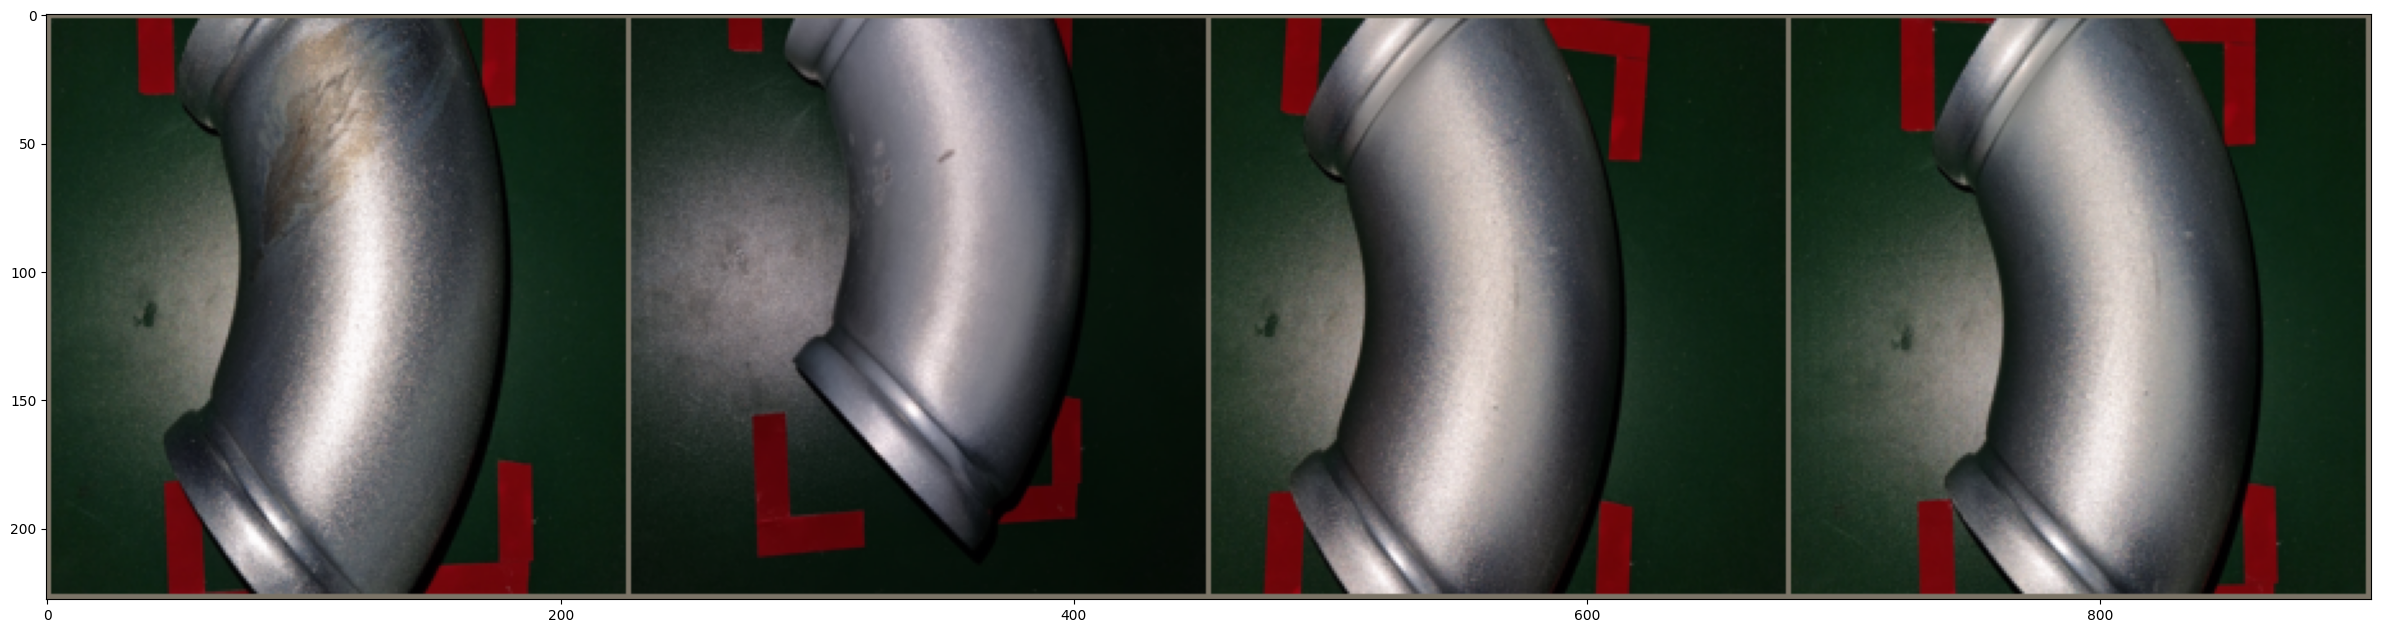

In [10]:
import matplotlib.pyplot as plt

def imshow(inp, title=None): 
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean 
    inp = np.clip(inp, 0, 1)
    
    plt.figure(figsize=[30, 30])
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

inputs, classes = next(iter(val_loader)) 
out = torchvision.utils.make_grid(inputs)
# class_names = train_dataset.dataset.classes

outputs = model(inputs.to(device))
_, preds = torch.max(outputs,1) 

# imshow(out, title=[class_names[x] for x in preds]) 
imshow(out) 

In [11]:
predicted_list = []
for x_test_batch, y_test_batch in test_loader:
    model.eval()
    y_test_batch = y_test_batch.to(device)
    x_test_batch = x_test_batch.to(device)
    
    y_pred_batch = model(x_test_batch)
    _, predicted = torch.max(y_pred_batch, 1)
    predicted_list.extend(predicted.cpu().numpy())  # 리스트 확장

# 클래스 레이블을 생성
true_labels = []
for _, labels in test_loader:
    true_labels.extend(labels.numpy())  # 리스트 확장

# sklearn의 classification_report 호출
from sklearn.metrics import classification_report
report = classification_report(true_labels, predicted_list)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        10

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



In [12]:
print(true_labels)
print(predicted_list)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
